<h1 align="center">Thymio Sheep - A way back to the green meadow</h1>
  <div style="text-align: center;">
    <figure>
      <img src="./ThymioSheep.png" alt="Thymio Sheep" style="width:40%; height:auto;">
      <figcaption>Thymio Sheep - (Image generated by ChatGPT-4 Dalle)</figcaption>
    </figure>
  </div>

### MICRO-452: *Basics of mobile robotics*
#### Prof. Francesco Mondada
#### Group 11
##### Project by : 
* Julien Dibiaggio &nbsp;&nbsp;&nbsp; 283183
* Elsa Heitz &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; 316735
* Shenrui Li &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 376397 
* David Revaz &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 315773


##### 2023-2024


On the 7th of december 2023, a few sheep escaped their meadow at the EPFL. Some are lost between the buildings.\
Thymio is one of them. He needs to find his way back to the green meadow, while avoiding the EPFL buildings and the other sheep. \
The goal of this project is to help Thymio to find his way back to the green meadow.

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import time
import tdmclient
import tdmclient.notebook
import threading
from IPython.display import Image
import random

import camera as cam
import vision_utils as utils
import global_nav as global_nav
import local_nav as local_nav
import global_display_functions as plt_glob


# Global structure

The global structure of the project is summarized in the diagram below. It combines the 4 integral parts of the project: vision, global navigation, Bayesian filtering and obstacle avoidance, and it forms a general outline of the way the Python code is structured. 


<figure>
  <img src="./Schema project.jpg" style="width:70%; height:auto;">
</figure>

# Vision System Implementation

This part of the report outlines the key implementation choices, made for the vision section of the project. The primary tasks of the vision system include detection of various colored objects – such as green goals, black obstacles, blue circles, and red shapes – and the extraction of spatial information, necessary for navigation and interaction within the environment. These tasks are achieved through color-based image segmentation and geometric transformations.

## Image preprocessing 

### Color Space Conversion to HSV

A fundamental aspect of the vision system's implementation is the decision to employ the Hue, Saturation, and Value (HSV) color space over the standard Blue, Green, and Red (BGR) color space. The HSV color space separates image luminance (intensity of light) from color information, which resides in the hue and saturation components. This separation is beneficial, because it reduces the system's sensitivity to variation in lighting conditions, thus affording more robust color detection. The use of HSV is particularly advantageous in differentiating between colors that have similar brightness levels but different tones, which is common in real-world environments.

At first, we did some tests of the image, created for the map as follows : 

In [22]:
# Load the image
image_numerical = cv2.imread('maps/numerical_map.jpeg')
image_real      = cv2.imread('maps/real_map.jpeg')

OpenCV employs the BGR image format, meaning that when utilizing *cv2.imread()*, images are automatically interpreted in the BGR format. [1]

In [23]:
# Inverse red and blue
image_numerical = cv2.cvtColor(image_numerical, cv2.COLOR_BGR2RGB)
image_real      = cv2.cvtColor(image_real, cv2.COLOR_BGR2RGB)

# Convert to HSV
hsv_numerical = cv2.cvtColor(image_numerical, cv2.COLOR_RGB2HSV)
hsv_real      = cv2.cvtColor(image_real, cv2.COLOR_RGB2HSV)

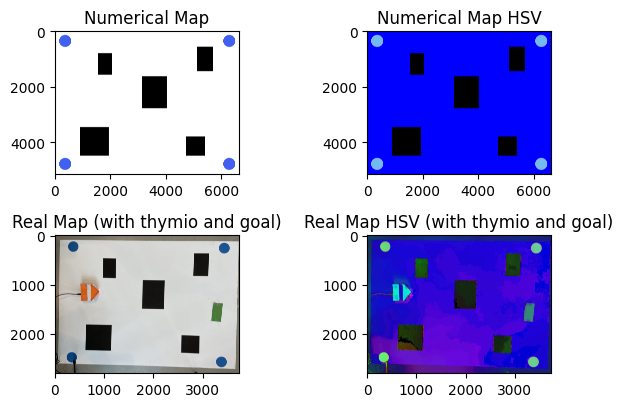

In [24]:
plt.subplot(2,2,1)
plt.imshow(image_numerical)
plt.title('Numerical Map')

plt.subplot(2,2,2)
plt.imshow(hsv_numerical)
plt.title('Numerical Map HSV')

plt.subplot(2,2,3)
plt.imshow(image_real)
plt.title('Real Map (with thymio and goal)')

plt.subplot(2,2,4)
plt.imshow(hsv_real)
plt.title('Real Map HSV (with thymio and goal)')

plt.subplots_adjust(hspace=0.2)  # Add space between the two lines
plt.subplots_adjust(wspace=0.7)  # Add space between the two columns

plt.show()

### Filtering Techniques

Bilateral filtering is employed on the HSV image before the segmentation, to reduce noise while preserving edge details. Unlike simple Gaussian filters, bilateral filtering considers both spatial proximity, as well as color similarity, which avoids blurring across color edges. This technique was chosen to improve the accuracy of contour detection, as precise edge localization is critical for geometric analysis and object differentiation. [2]

As well as the image, the function takes $d$, $\sigma_{Color}$ and $\sigma_{Space}$ as arguments :

* $d$ : The size of the pixel neighborhood utilized in filtering is determined by its diameter. When this value is not positive, it's calculated based on $\sigma_{Space}$.
* $\sigma_{Color}$ : A value in the color space, which decides the filter strength. A larger value means colors further apart are considered as similar.
* $\sigma_{Space}$ : A value in the coordinate space, which determines the filter sigma in the position domain. A larger value means pixels far from one another will influence each other as long as their colors are close enough.

Values of $\sigma_{Color}$ and $\sigma_{Space}$ have been found empirically during the vision debugging phase.

In [ ]:
DISTANCE    = 9
SIGMA_COLOR = 80
SIGMA_SPACE = 80

# Apply bilateral filter to hsv image
hsv_real_filtered = cv2.bilateralFilter(hsv_real, DISTANCE, SIGMA_COLOR, SIGMA_SPACE)

### Adaptive Thresholding for Color Segmentation

After applying the filter, an adaptive thresholding approach is implemented to define ranges for each color of interest. This method is chosen to accommodate the variability in color appearance, caused by factors such as shadows, reflections, and inconsistent lighting. By dynamically setting the lower and upper bounds of color ranges with specified thresholds for HSV components, more consistent detection is reached across different conditions.

Fun fact: we had issues with red detection so we changed it with orange and it worked better. From this moment, orange became the new red.

In [26]:
# Define color ranges for every colored shape
black_lower, black_upper = cam.black_range_hsv(cam.BRIGHTNESS_THRESHOLD-1)
green_lower, green_upper = cam.hsv_range(cam.GREEN_BGR, cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)
red_lower  , red_upper   = cam.hsv_range(cam.RED_BGR,   cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)
blue_lower , blue_upper  = cam.hsv_range(cam.BLUE_BGR,  cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)

# Create masks for every color
black_mask  = cv2.inRange(hsv_real_filtered, black_lower, black_upper)
green_mask  = cv2.inRange(hsv_real_filtered, green_lower, green_upper)
red_mask    = cv2.inRange(hsv_real_filtered, red_lower  , red_upper)
blue_mask   = cv2.inRange(hsv_real_filtered, blue_lower , blue_upper)

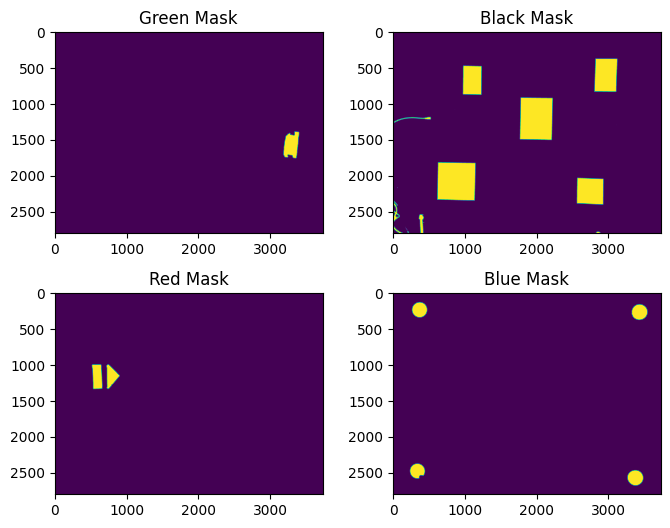

In [27]:
# Plot the masks
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.imshow(green_mask)
plt.title('Green Mask')

plt.subplot(2,2,2)
plt.imshow(black_mask)
plt.title('Black Mask')

plt.subplot(2,2,3)
plt.imshow(red_mask)
plt.title('Red Mask')

plt.subplot(2,2,4)
plt.imshow(blue_mask)
plt.title('Blue Mask')

plt.subplots_adjust(hspace=0.3)  # Add space between the two lines

plt.show()

### Geometric Figure Detection

In addition to color detection, the vision system implements contour-based geometric figure detection to distinguish among various shapes. This approach allows for identifying specific objects, such as black rectangles representing obstacles, and triangular and rectangular red shapes marking the robot's own presence. By leveraging the geometric properties of contours, the system can calculate moments to find centroids and thereby recognize the position and orientation of objects and the robot itself. [3]

In [28]:
# Find contours for each colour and keep only the ones with area greater than a certain threshold
blue_contours, _    = cv2.findContours(blue_mask    , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
green_contours, _   = cv2.findContours(green_mask   , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _   = cv2.findContours(black_mask   , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
red_contours, _     = cv2.findContours(red_mask     , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the real image
cv2.drawContours(image_real, blue_contours  ,  -1, (255, 255, 0), 20); # Yellow color for blue circles
cv2.drawContours(image_real, black_contours ,  -1, (255, 0  , 0), 20); # Red   contour for black squares
cv2.drawContours(image_real, green_contours ,  -1, (0  , 255, 0), 20); # Green contour for green squares
cv2.drawContours(image_real, red_contours   ,  -1, (0  , 0  , 0), 20); # Black contour for red   squares

We can see here that other elements are detected (robot wire, small red dot next to the green goal, etc.). While the code is running, the following lines are included, in order not to detect other elements that might not be the actual objects we want. It happened that wearing blue shoes or having a red bottle close to the map resulted in computation bugs.

```python
blue_contours  = [cnt for cnt in blue_contours  if cv2.contourArea(cnt) > CIRCLE_AREA_THRESHOLD]
green_contours = [cnt for cnt in green_contours if cv2.contourArea(cnt) > RECTANGLE_AREA_THRESHOLD]
black_contours = [cnt for cnt in black_contours if cv2.contourArea(cnt) > RECTANGLE_AREA_THRESHOLD]
red_contours   = [cnt for cnt in red_contours   if cv2.contourArea(cnt) > RED_AREA_THRESHOLD]

### Perspective Transformation

The vision system implements a perspective transformation to normalize the view of the scene, effectively unwrapping the camera's view into a bird's-eye perspective. This choice is particularly relevant when dealing with planar objects positioned at different angles and distances from the camera. Perspective transformation simplifies the spatial relationship between objects, enabling more straightforward path planning and navigation tasks.\
This transformation is only applied when the 4 blue circles are detected. The following code is used to compute the transformation matrix and apply it to the image.
```python
if len(blue_coordinates) == 4:
                # Compute the perspective transform matrix and then apply it
                bcoor = [b[0] for b in blue_coordinates]
                src = np.array(bcoor, dtype="float32")
                dst = np.array([(height,width), (0,width), (height,0), (0,0)], dtype="float32")
                M = cv2.getPerspectiveTransform(src, dst)
                frame = cv2.warpPerspective(frame, M, (height, width))
                bc = [transform_point(b[0],M) for b in blue_coordinates]
                width,height,origin = compute_transform_dimensions(bc)
                if height < width:
                    tmp = height
                    height = width
                    width = tmp



### Coordination with Navigation

The vision system's output includes coordinate transformations between the image plane and the real-world plane, which are crucial for the robot's interaction with its environment. By providing transformations between image space and a real-world coordinate system, the system ensures that detected objects can be located accurately within the robot's map, facilitating successful navigation and task execution.

The formulas we computed are the following :

$$
\begin{align*}
\left\{
\begin{array}{l}
x_r=\frac{MAP\_WIDTH}{\text { width }} \cdot x_{O C} \\[10pt]
y_r=\frac{\text { MAP\_HEIGHT }}{\text { height }} \cdot y_{O C}
\end{array}
\right.
&
\text{with}
&
\left\{
\begin{alignat*}{2}
x_{0 c} & {[\text {pixel}]} && \quad \text {coordinates of the camera system} \\
y_{0 c} & {[\text {pixel}]} && \quad \text {coordinates of the camera system} \\
x_r & {[\mathrm{~cm}]} && \quad \text {coordinates of our own system} \\
y_r & {[\mathrm{~cm}]} && \quad \text {coordinates of our own system} \\
MAP\_WIDTH & {[\mathrm{~cm}]} && \quad \text {real size of the map, equals 75cm} \\
MAP\_HEIGHT & {[\mathrm{~cm}]} && \quad \text {real size of the map, equals 100cm} \\
height & {[\text {pixel}]} && \quad \text {measured in real time} \\
width & {[\text {pixel}]} && \quad \text {measured in real time} \\
\end{alignat*}
\right.
\end{align*}
$$


<figure>
    <img src="./maps/coordinates_system_computation.jpeg"style="width:75%; height:auto;">
    <figure>

### Modular and Versatile Functionality

Throughout the implementation, the vision system was designed to be modular and adaptable to different visualization and real-time processing modes. By including parameters and modes that can be adjusted, the system can be tailored for various use cases and can be easily integrated with other sub-systems within the robot's architecture.

# Global Navigation

#### Setting Parameters to display

In [29]:
object_corners= [[(17.821782178217823, 80.86021505376344), (3.7128712871287126, 80.86021505376344), (3.7128712871287126, 90.3225806451613), (17.821782178217823, 90.3225806451613)], 
                 [(20.04950495049505, 20.43010752688172), (7.425742574257425, 20.43010752688172), (7.425742574257425, 28.602150537634408), (20.04950495049505, 28.602150537634408)], 
                 [(40.59405940594059, 47.31182795698925), (21.78217821782178, 47.31182795698925), (21.78217821782178, 61.72043010752688), (40.59405940594059, 61.72043010752688)], 
                 [(68.81188118811882, 9.67741935483871), (52.227722772277225, 9.67741935483871), (52.227722772277225, 26.451612903225808), (68.81188118811882, 26.451612903225808)], 
                 [(69.3069306930693, 73.97849462365592), (58.415841584158414, 73.97849462365592), (58.415841584158414, 85.3763440860215), (69.3069306930693, 85.3763440860215)]]

object_corners = global_nav.create_dictionnary(object_corners)
RandG = {'robot': (30, 85), 
         'goal': (34.65346534653465, 7.956989247311828)}

robot_size = 9

#### Growing obstacles

The function *grow_obstacles* is defined for quadrilaterals, since it was decided in our group to only use quadrilaterals as obstacles, to ease the implementation of the shapes recognition. This method takes the position of the opposite points and adds or removes a value of *robot_size* in x- and in y-direction. Theoretically, the value of *robot_size* is half of the robot dimension, but in reality, this parameter had to be tuned, to achieve the optimal result. Hence, it will grow the obstacles, to avoid collision of the robot with them.
To add or remove a certain value in x and y, the following possibilities (case 1 to 4) were considered.

<figure>
  <img src="./IMG_20CC1C4CB37F-1.jpeg" style="width:50%; height:auto;">
</figure>

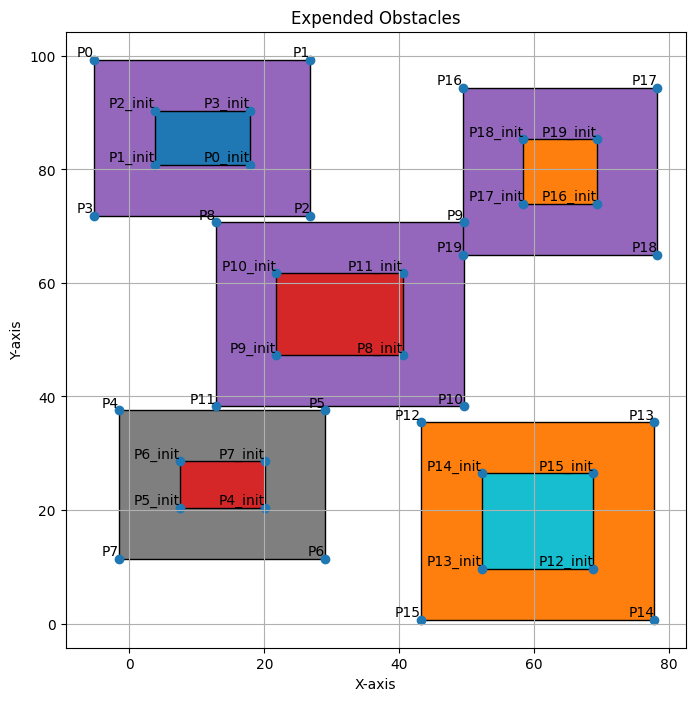

In [30]:
expended_corners = global_nav.grow_obstacles(object_corners, robot_size)
plt_glob.plot_expended_obstacles(object_corners, RandG, expended_corners)

### Finding the shortest path

Our group chose a map with printed obstacles. Thus, these obstacles are seen only from top camera and not from the proximity sensors of the Thymio. The reason for this choice is that these obstacles needed to be avoided, only using a global path planning. Moreover, we decided to use a gridless map. In this way, the optimal choice of algorithm for the global path planning was the Dijkstra algorithm [4]. Generally, this algorithm is more flexible than most other algorithms, covered in the lectures, and doesn't rely on a grid structure. It is an algorithm that can adapt to various shapes of obstacles. Furthermore, the Dijkstra algorithm is known to be very efficient at working with weighted graphs. In this context, the weights are the distances between the points. The algorithm is optimal, since it guarantees finding a solution, that will minimize the distance for any point in the map. However, the computational cost of this algorithm becomes high, if the map is too large, or if there are too many connections. In our case, it is sufficiently robust, since the map is relatively small and doesn't have a great number of connections.

At first, an adjacency list is created, which is able to determine if two points are connected. In order to make this happen, a function was created, detecting the intersection of two line segments. Using the theory about point orientation [5], I created a function *compute_orientation*, which returns the orientation of three given points. All points are defined as tuples, corresponding to x- and y-coordinates. Afterwards, the function *intersect* finds out if segments are connected, going through every case of orientation. 
The following plot is used, to test the *intersect* function on 2 random segments: 

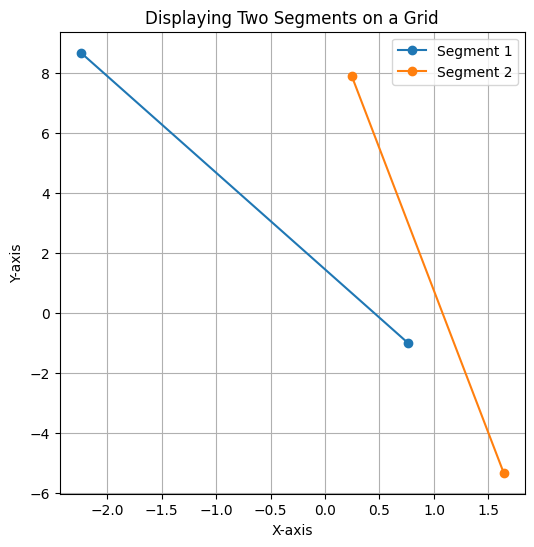

Are the segments crossing?  False


In [31]:
point1 = (random.uniform(-10, 10), random.uniform(-10, 10))
point2 = (random.uniform(-10, 10), random.uniform(-10, 10))
point3 = (random.uniform(-10, 10), random.uniform(-10, 10))
point4 = (random.uniform(-10, 10), random.uniform(-10, 10))
plt_glob.display_segments(point1, point2, point3, point4)
print("Are the segments crossing? ",global_nav.intersect (point1,point2,point3,point4))

Using this, it can be seen that two points are connected, if a line can be drawn between them, without crossing any object segments. The function *adjacency_list* goes through every point and creates a new dictionnary, giving the connection between separate points.

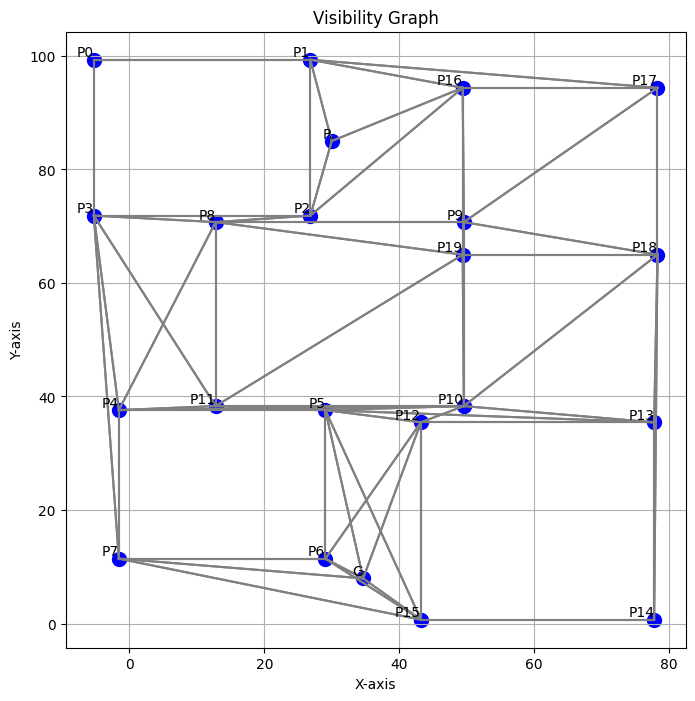

In [32]:
points_name2coord = global_nav.name2coord(expended_corners, RandG)
adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
plt_glob.plot_visibility_graph(adjacent_list, points_name2coord)

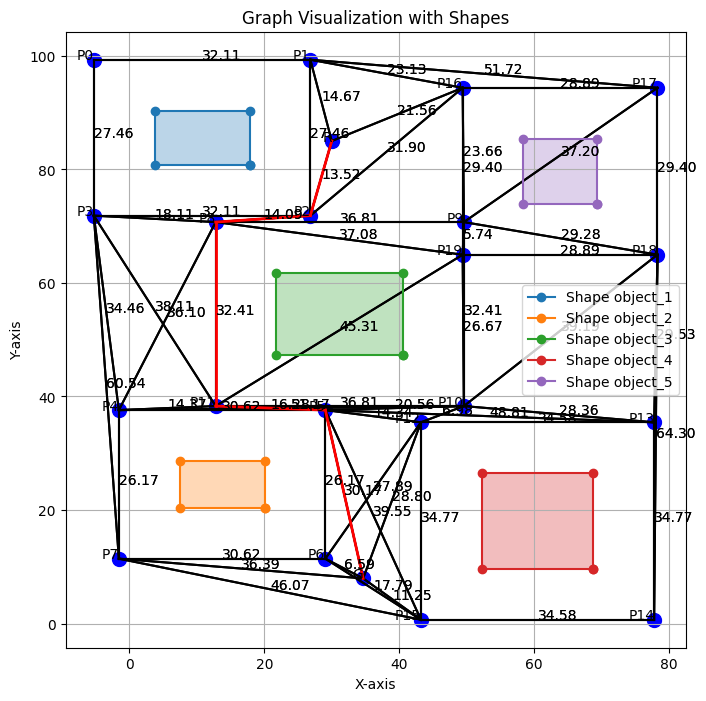

In [33]:
distances = global_nav.calculate_distances(adjacent_list, points_name2coord)

[short_path, adjacent_list, points_name2coord] = global_nav.shortest_path(RandG, object_corners, expended_corners)

path=[]
for name in short_path:
    path.append(points_name2coord[name])

short_path = short_path.reverse()
plt_glob.plot_graph_with_shapes(adjacent_list, points_name2coord, distances, path, object_corners)

### Case where the robot ends up inside an expanded obstacle

After the robot avoids a local obstacle, put in front of it, it computes a new global path. During the local obstacle avoidance, the situation could occur, where the robot finds itself inside a grown obstacle. In this case, when the robot searches for a new global path, it could happen that the closest point is on the other side of an obstacle. Hence, this special case needs to be considered as well. If the robot gets in this zone, the adjacency list is updated, so that only the points that don't cross the real obstacles, are connected. In this way, if the robot somehow got into an obstacle, it will go to the extended obstacle corner, which is the closest to the end goal and find the shortest path from there.

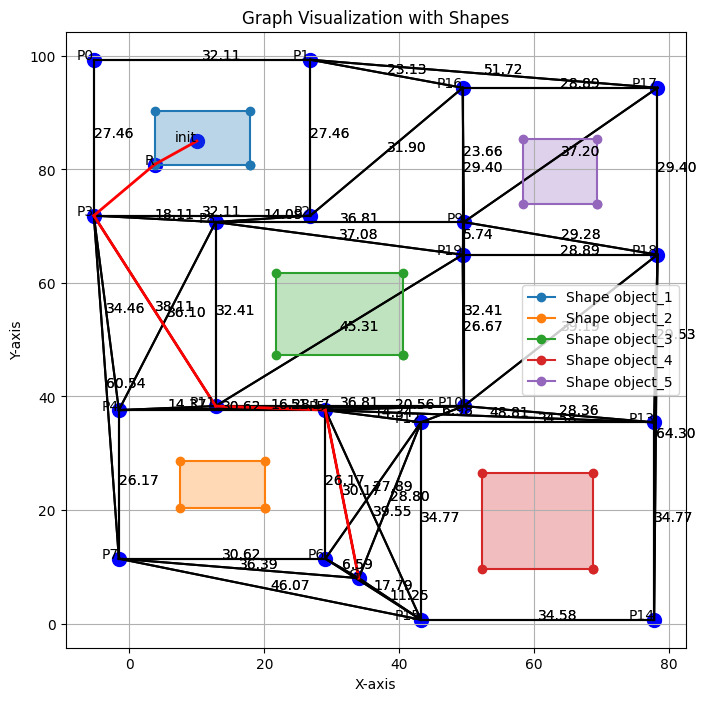

In [34]:
RandG = {'robot': (10, 85), 
         'goal': (34, 8)}

adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
distances = global_nav.calculate_distances(adjacent_list, points_name2coord)
[short_path, adjacent_list, points_name2coord] = global_nav.shortest_path(RandG, object_corners, expended_corners)
path=[]
for name in short_path:
    path.append(points_name2coord[name])

short_path = short_path.reverse()
plt_glob.plot_graph_with_shapes(adjacent_list, points_name2coord, distances, path, object_corners)

# From global navigation to Bayesian filtering

The Bayesian filtering uses the coordinates from the global navigation (path planning) to calculate the local path of the robot. The first coordinate of the path, given by the global navigation, is the current position of the robot. Using the filtering, the robot moves towards the next coordinate in the path, seeing it as its target. Upon reaching the target, the next coordinate in the path becomes the next target. In this way, the robot makes its way towards its ultimate end goal. 

# Bayesian filtering

For the filtering part, we decided to use a Kalman filter, since the noise of the robot state has approximately a Gaussian distribution. The components of the robot state will be further clarified in the section named *Kalman filter*. Furthermore, the Kalman filter works well for linear systems, which applies for the system that is used in this project. In general, it also has a lower computational cost than other popular filters, such as the Extended Kalman Filter (EKF), the particle filter (Monte Carlo Localization) and the Markov Localisation. For complex, nonlinear models, these other filters are effective, but for this project, the Kalman filter remains the most efficient, computationally and conceptually.

## Kalman filter

Together, the *predict* and *measure* functions make up the Kalman filter [6]. The *predict* function predicts the next state of the robot, which comprises of a vector of 6 components: $[x, y, \dot{x}, \dot{y}, \theta, \dot{\theta}]^T$. The 6 components represent respectively the x-position, the y-position, the x-velocity, the y-velocity, the angle of the robot $\theta$ towards the reference frame and angular velocity. The mean of the next state is predicted by $x[k+1]= Ax[k] + Bu[k]$, and the covariance noise of the next state is also predicted, using the previous covariance noise and the process noise.

This prediction is not entirely correct, mainly due to the process noise. This is why this predicted state is corrected by the *measure* function. This function updates the state values, with the help of a camera, that detects the position (x- and y-coordinate) and the orientation (angle) of the robot. Using the innovation, which is the error between the position prediction and the camera detected position, and the variance of the innovation, the Kalman gain *K* is calculated. With the help of this feedback system, the state of the robot is corrected.

When the camera is hidden, the second part of the Kalman filter (*measure*) is bypassed, since it needs the camera measured position to compute the next state. In this case, only the prediction is used for the next computation of the Kalman filter. Every time when only the prediction step is applied, the Gaussian curve of the estimated state becomes flatter, more spread out and less peaked. This is due to the fact that the camera measurement is not present to correct the prediction.

## Proportional controller


The function *go_to_target* uses the position of the robot, estimated by the Kalman filter, to determine its next steps. The linear speed of the motors is calculated, using 2 control coefficients: the angle coefficient and distance coefficient.
The angle coefficient is 0, when the angle difference between the current orientation of the Thymio and the orientation it needs to have to reach its next target is bigger than 90°. When this is the case, the linear speed is zero, since the Thymio will only turn around and not go forward. The smaller the angle difference is, the bigger the angle coefficient and subsequently the linear speed of the Thymio will be. This leads to the Thymio going faster, when its orientation is in the correct direction.
The distance coefficient is 1, as long as the Thymio is still quite far away (further than 10 *cm*) from its next target. When the Thymio gets closer to its target, the distance coefficient will decrease, so that the Thymio slows down, making sure it won't miss or surpass its target. The plots of the angle coefficient and the distance coefficient can be found below.

Furthermore, a proportional controller is applied, using the angle difference. The angle gain is determined experimentally, and the control angle depends on the angle difference. The bigger the angle difference is, the bigger the speed difference between the two wheels of the Thymio is. This causes the Thymio to turn faster, when the angle difference is great.

The coefficient "300" in *speed_forward* is also calculated experimentally, to choose the overall speed of the Thymio.


<figure>
    <img src="angle_coefficient.jpg" style="width:50%; height:auto;">
</figure>

<figure>
    <img src="distance_coefficient.jpg" style="width:50%; height:auto;">
</figure>

# Obstacle avoidance
The obstacle avoidance is done directly inside the Thymio robot, using the proximity sensors to detect obstacles and avoid them. If the robot detects an obstacle, it will turn to the left or right, depending on which side the obstacle is located.
If the robot detects an obstacle, its state will change to 1, which is defined as the avoidance state.\
This state is synchronized with the state of the robot in the navigation thread, so that when it leaves the avoidance state, it will immediately ask for a new global path.
The speed of each wheel of the robot is controlled by the navigation thread and synchronized with *tdmclient*.

## Avoidance code inside the Thymio
```python
speed_left_global = 0
speed_right_global = 0
obstSpeedGain = [10, 4, -2, -6, -12]
state_global = 0
DELTA = 1
PROX_TRESHOLD = 200
timer_period[0] = 10  # 10ms sampling time

@onevent 
def timer0():
    global prox_ground_delta, prox_horizontal, speed0, speedGain,obstSpeedGain, motor_left_target, motor_right_target
    global speed_left_global, speed_right_global, state_global, motor_left_speed, motor_right_speed
    spLeft = speed_left_global
    spRight = speed_right_global
    state_global = 0
    side_obstacle = False
    # adjustment for obstacles ("gradient" due to obstacles)
    for i in range(5):
        spLeft += prox_horizontal[i] * obstSpeedGain[i] // 100
        spRight += prox_horizontal[i] * obstSpeedGain[4 - i] // 100
        if prox_horizontal[i] > PROX_TRESHOLD:
            state_global = 1
        if 0 < i and i < 4:
            if (prox_horizontal[0] > PROX_TRESHOLD or prox_horizontal[4] > PROX_TRESHOLD ) and prox_horizontal[i] < PROX_TRESHOLD:
                side_obstacle = True
            else:
                side_obstacle = False

    if side_obstacle:
        if prox_horizontal[0] > PROX_TRESHOLD:
            spLeft += 5
            spRight += 15
        if  prox_horizontal[4] > PROX_TRESHOLD:
            spLeft += 15
            spRight += 5  


    # motor control
    motor_left_target = spLeft
    motor_right_target = spRight



## Synchronization function with the navigation thread
```python
@tdmclient.notebook.sync_var
def thymio_speed(speed_left,speed_right):
    global speed_left_global
    global speed_right_global
    speed_right_global = speed_right
    speed_left_global = speed_left

@tdmclient.notebook.sync_var
def thymio_state(has_global_path):
    global state_global
    thymio_state = "Local"
    if state_global == 1:
        thymio_state = "Avoidance"
        has_global_path = False
    return thymio_state, has_global_path

def thymio_turn(angle_diff):
    if abs(angle_diff) > 10:
        if angle_diff > 0:
            thymio_speed(-50,50)
            time.sleep(0.05*angle_diff)
            thymio_speed(0,0)
            time.sleep(0.1)
        else:
            thymio_speed(50,-50)
            time.sleep(0.05*abs(angle_diff))
            thymio_speed(0,0)
            time.sleep(0.1)
        return angle_diff*math.pi/180 # return in radians
    return 0


## References

[1] soumibardhan10, *Convert BGR and RGB with Python – OpenCV*, https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/ \
[2] Sylvain Paris – MIT CSAIL, *A Gentle Introduction to Bilateral Filtering and its Applications*, https://people.csail.mit.edu/sparis/bf_course/slides/03_definition_bf. \
[3] *OpenCV : Contours : Getting started. (s. d.).*, https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html \
[4] :
* Francesco Mondada, 2023, slides of the course Basics of Mobile robotics
* Yvan Monka, "Utiliser l'algorithme de Dijkstra - PostBac" [video] https://youtu.be/rHylCtXtdNs?si=AHIMcMFKq95xQKFB
* Alexey Klochay, "Implementing Dijkstra’s Algorithm in Python", [webpage], Udacity, https://www.udacity.com/blog/2021/10/implementing-dijkstras-algorithm-in-python.html

[5] : 
* GeeksforGeeks, "How to check if two given line segments intersect?" [Video] https://www.youtube.com/watch?v=wCR48FqkI4w
* Geeksforgeeks, How to check if two given line segments intersect? (13 Jul, 2022) [webpage] https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

[6] : Francesco Mondada, 2023, slides of the course Basics of Mobile robotics

# Video of the project
<video width = "960" height = "540" controls>
  <source src = "./ThymioSheep.mp4" type = "video/mp4">
</video>

**=========================================================================**
# RUN the following cells to start the demo
The following cells will run the demo. You can run the cells one by one by pressing the play button or you can run all the cells by clicking on the menu Cell -> Run All.

In [2]:
global robot,goal, object_corners
object_corners =[]
robot=()
goal=()





In [3]:
await tdmclient.notebook.start()

In [4]:
@tdmclient.notebook.sync_var
def thymio_speed(speed_left,speed_right):
    global speed_left_global
    global speed_right_global
    speed_right_global = speed_right
    speed_left_global = speed_left

@tdmclient.notebook.sync_var
def thymio_state(has_global_path):
    global state_global
    thymio_state = "Local"
    if state_global == 1:
        thymio_state = "Avoidance"
        has_global_path = False
    return thymio_state, has_global_path

def thymio_turn(angle_diff):
    if abs(angle_diff) > 10:
        if angle_diff > 0:
            thymio_speed(-50,50)
            time.sleep(0.05*angle_diff)
            thymio_speed(0,0)
            time.sleep(0.1)
        else:
            thymio_speed(50,-50)
            time.sleep(0.05*abs(angle_diff))
            thymio_speed(0,0)
            time.sleep(0.1)
        return angle_diff*math.pi/180 # return in radians
    return 0

@tdmclient.notebook.sync_var
def print_thymio_speed():
    global motor_left_speed, motor_right_speed
    mls = motor_left_speed
    mrs = motor_right_speed
    print("Left motor speed: ", mls)
    print("Right motor speed: ", mrs)

In [5]:
thymio_speed(0,0)

In [6]:
%%run_python
speed_left_global = 0
speed_right_global = 0
obstSpeedGain = [10, 4, -2, -6, -12]
state_global = 0
DELTA = 1
PROX_TRESHOLD = 200
timer_period[0] = 10  # 10ms sampling time

@onevent 
def timer0():
    global prox_ground_delta, prox_horizontal, speed0, speedGain,obstSpeedGain, motor_left_target, motor_right_target
    global speed_left_global, speed_right_global, state_global, motor_left_speed, motor_right_speed
    spLeft = speed_left_global
    spRight = speed_right_global
    state_global = 0
    side_obstacle = False
    # adjustment for obstacles ("gradient" due to obstacles)
    for i in range(5):
        spLeft += prox_horizontal[i] * obstSpeedGain[i] // 100
        spRight += prox_horizontal[i] * obstSpeedGain[4 - i] // 100
        if prox_horizontal[i] > PROX_TRESHOLD:
            state_global = 1
        if 0 < i and i < 4:
            if (prox_horizontal[0] > PROX_TRESHOLD or prox_horizontal[4] > PROX_TRESHOLD ) and prox_horizontal[i] < PROX_TRESHOLD:
                side_obstacle = True
            else:
                side_obstacle = False

    if side_obstacle:
        if prox_horizontal[0] > PROX_TRESHOLD:
            spLeft += 5
            spRight += 15
        if  prox_horizontal[4] > PROX_TRESHOLD:
            spLeft += 15
            spRight += 5  


    # motor control
    motor_left_target = spLeft
    motor_right_target = spRight




In [7]:
def nav_thread():
    global robot_pos,goal, object_corners, angle_robot,path,kalman_pos, run
    state = 'Local'
    has_gobal_path = False
    robot_pos = None
    goal = None
    angle_robot = 0
    robot_size = 12
    run = False
    counter = 0
    path = []
    kalman_pos = []
    while True:
        if run == False:
            has_gobal_path = False
            counter = 0
        else:
            state,has_gobal_path = thymio_state(has_gobal_path)
            robot = robot_pos
            if state == "Local":
                if not has_gobal_path:
                    if robot is not None and goal != []:
                        path = []
                        RandG = global_nav.create_RandG_dict(robot, goal)
                        object_corners = global_nav.create_dictionnary(object_corners)
                        expended_corners = global_nav.grow_obstacles(object_corners, robot_size)
                        points_name2coord = global_nav.name2coord(expended_corners, RandG)
                        adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
                        distances = global_nav.calculate_distances(adjacent_list, points_name2coord)
                        [short_path,adjacent_list,points_name2coord ] = global_nav.shortest_path(RandG, object_corners,expended_corners)
                        for name in short_path:
                            path.append(points_name2coord[name])
                        has_gobal_path = True
                        counter = 0
                        if path != []:
                            x_pos = path[0][0]
                            y_pos = path[0][1]
                            theta = angle_robot
                            initial_state = np.array([x_pos, y_pos, 0.0, 0.0, theta, 0])   # the angle of the robot is determined by the camera (at the start)
                            initial_covariance = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])   # initial state matrix
                            process_noise = np.diag([0.03, 0.03, 0.01, 0.01, 0.02, 0.01])   # process noise covariance matrix, determined experimentally
                            measurement_noise = np.array([0.1, 0.1])   # measurement noise variance of camera, determined experimentally

                            # Initialize Kalman filter
                            local_state = initial_state
                            covariance = initial_covariance   
                            time_prev = time.time()
                            new_left_speed = 0
                            new_right_speed = 0
                            cor = 2 #correction factor for the target coordinates (2 cm)
                            
            # for local state
            if path != []:

                coordinate = path[counter+1]

                if local_nav.check_target(local_state, coordinate, cor) == True:
                    cam_working = robot is not None
                    
                    if cam_working and angle_robot is not None: # if the camera is not hidden
                        theta = angle_robot
                    else:
                        theta = local_state[4]

                    left_speed = new_left_speed
                    right_speed = new_right_speed
                    input_val = np.array([local_nav.convert_speed(left_speed), local_nav.convert_speed(right_speed)])

                    # the sampling time is calculated, using the time that went by, since the previous loop 
                    Ts = time.time() - time_prev
                    time_prev = time.time()

                    local_state, covariance = local_nav.predict(local_state, input_val, covariance, Ts, theta, process_noise) 

                    local_state, covariance = local_nav.measure(local_state, covariance, cam_working, measurement_noise, robot)               
                    
                    if (local_state[0], local_state[1]) == path[0]:   # the first time the Kalman filter updates, the position will still be zero
                        local_state, covariance = local_nav.predict(local_state, input_val, covariance, Ts, theta, process_noise)              
                        local_state, covariance = local_nav.measure(local_state, covariance, cam_working, measurement_noise, robot)                
                    
                    kalman_pos = [local_state[0], local_state[1]]

                    if local_nav.check_target(local_state, coordinate, cor) == True:   # if the target position is already reached after updating the Kalman filter, the speed will go to zero
                        new_left_speed, new_right_speed = local_nav.go_to_target((local_state[0],local_state[1]), coordinate, theta)
                        thymio_speed(new_left_speed, new_right_speed)

                    else:
                        thymio_speed(0, 0)

                else:
                    counter += 1
                    if counter == len(path)-1:
                        thymio_speed(0,0)
                        run = False



In [8]:
nav_thread = threading.Thread(target=nav_thread)

***Camera Thread***

In [9]:
import traceback
def camera_thread():
    global robot_pos, goal, object_corners, angle_robot, cov_noise ,height, path ,kalman_pos, run      

    FONT = cv2.FONT_HERSHEY_SIMPLEX
    TEXT_POS = (150, 50)  # Position of text (x, y)
    FONT_SCALE = 1
    TEXT_COLOR = (0, 0, 0)  # Black color
    THICKNESS = 1


    try:
        camera_index = 0
        # If you are to use the cam object, make sure it is defined and initialized
        # data = cam.capture_data(camera_index)
        # cov_noise = cam.calculate_covariance_matrix(data)
        cap = cv2.VideoCapture(camera_index)
        
        if not cap.isOpened():
            print("Error opening video stream or file")
            return

        mode = 'all'
        color_type = 'RGB'

        # Define thresholds initially
        threshold  = [cam.COLOR_THRESHOLD,cam.SATURATION_THRESHOLD,cam.BRIGHTNESS_THRESHOLD]

        cv2.namedWindow("Camera Vision", cv2.WINDOW_NORMAL)
        # Create Trackbars
        cv2.createTrackbar("Color Threshold", "Camera Vision", threshold[0], 200,
                        lambda x: utils.on_trackbar(x, threshold, 0))
        cv2.createTrackbar("Saturation Threshold", "Camera Vision", threshold[1], 200,
                        lambda x: utils.on_trackbar(x, threshold, 1))
        cv2.createTrackbar("Brightness Threshold", "Camera Vision", threshold[2], 200,
                        lambda x: utils.on_trackbar(x, threshold, 2))
        height = 100
        width =75
        origin = (0,0)
        path = []
        kalman_pos = []
        run = False

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cam.zoom_frame(frame,zoom_factor=1)

            # Camera vision
            frame, robot_pos, angle_robot, goal, object_corners, map_corners,width, height,origin = cam.detection(
                frame,
                mode,
                color_type,
                threshold[0],  # Color threshold
                threshold[1],  # Saturation threshold
                threshold[2],  # Brightness threshold
                width,
                height,
                origin,
            )

            #Display the path on the frame
            if path != []:
                path_in_frame = [cam.IRL_to_coordinate(p,width,height,origin) for p in path]
                utils.draw_path(frame,path_in_frame)
            if kalman_pos != []:
                if cam.coordinate_in_map(kalman_pos,width,height):
                    kpos = cam.IRL_to_coordinate(kalman_pos,width,height,origin)
                    utils.draw_point(frame,kpos)
            if run == False:
                cv2.putText(frame, "Stopped", TEXT_POS, FONT, FONT_SCALE, TEXT_COLOR, THICKNESS)
            else:
                cv2.putText(frame, "Running", TEXT_POS, FONT, FONT_SCALE, TEXT_COLOR, THICKNESS)

            cv2.imshow("Camera Vision", frame)

            key = cv2.waitKey(25) & 0xFF
            if key == 27:  # ESC key to exit
                break
            elif key == ord('1'):  # '1' key to switch to blue mode
                mode = 'blue'
            elif key == ord('2'):  # '2' key to switch to green mode
                mode = 'green'
            elif key == ord('3'):  # '3' key to switch to black mode
                mode = 'black'
            elif key == ord('4'):  # '4' key to switch to black mode
                mode = 'red'
            elif key == ord('5'):  # '5' key to switch to RGB mode
                color_type = 'RGB'
            elif key == ord('6'):  # '6' key to switch to BGR mode
                color_type = 'BGR'
            elif key == ord('7'):
                mode = 'all'
            
            elif key == ord('r'):
                run = True
            elif key == ord('s'):
                run = False
                
            time.sleep(0.01)

    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Done displaying the video")


**Camera Thread**\
This tread is deactivated by default and the camera is run just as a regular cell to improve the performance of the camera. If you want to run the camera thread, you can uncomment the following cell and run it and comment the last one.

In [10]:
#camera_thread = threading.Thread(target=camera_thread)

In [11]:
#camera_thread.start()

In [12]:
nav_thread.start()

In [13]:
camera_thread()

Done displaying the video
